# this is to show how double transport affect j_SEI, produce Fig. 7

In [1]:
# magic lines that avoid re-start
%load_ext autoreload
%autoreload 2
import pybamm;import pandas as pd   ;import numpy as np;import os;import matplotlib.pyplot as plt;import os;#import imageio
from scipy.io import savemat,loadmat;from pybamm import constants,exp,sqrt;
import matplotlib as mpl; 
fs=17; # or we can set import matplotlib.pyplot as plt then say 'mpl.rc...'
import openpyxl
import traceback
import multiprocessing
font = {'family' : 'Times New Roman','size'   : fs}
mpl.rc('font', **font)

In [2]:
import sys  
str_path_0 = os.path.abspath(os.path.join(pybamm.__path__[0],'..'))
str_path_1 = os.path.abspath(os.path.join(str_path_0,"wip/Rio_Code/Fun_P3"))
sys.path.append(str_path_1) 
from Fun_P3 import *
BasicPath = os.path.expanduser("~/EnvPBGEM_ECDrag2/Double_SimSave/Double_Trans/")
Target  = 'OneCycAge_240313/'
if not os.path.exists(BasicPath + Target):
   os.mkdir(BasicPath + Target)
Save_Fig = True

In [3]:
# define parameter of double and single 
# define parameter of double and single 
Para_dict_Same = {
   "Mesh list":[ [20,10,20,100,20], ],   # Simon uses 30
   "Para_Set":[ "Li2023_ECdrag",],
   "Contact resistance [Ohm]":[12e-3],
   "Initial Neg SOC":[0.8841301667966484,],
   "Initial Pos SOC":[0.23552755074598045,],
   "Inner SEI lithium interstitial diffusivity [m2.s-1]":[5e-19,],
}

Para_dict_DD_ONLY = {
   "Model option":[{
      "SEI":"interstitial-diffusion limited",   
      "SEI film resistance":"distributed",   
      "SEI porosity change": "true",
      "solvent diffusion": "double spatial consume w refill",
      "electrolyte conductivity": "sol full"  ,
     "contact resistance":"true",  },],
   "Lithium ion EC cross diffusivity [m2.s-1]":[0,1.5e-11], # 
}
Para_dict_SD_ONLY = {
   "Model option":[{
      "SEI":"interstitial-diffusion limited",   
      "SEI film resistance":"distributed",   
      "SEI porosity change": "true",
      "solvent diffusion": "single no consume wo refill",
      "electrolyte conductivity": "full"  ,
      "contact resistance":"true",  },],
   "Lithium ion EC cross diffusivity [m2.s-1]":[0,], #  
   "Measured dLJP_dce":["dLJP_1_Specie_dc_e_np",]
}
Para_dict_DD = {**Para_dict_Same,**Para_dict_DD_ONLY}
Para_dict_SD = {**Para_dict_Same,**Para_dict_SD_ONLY}
Para_DD = [];  Para_SD=[];
recursive_scan(Para_DD,Para_dict_DD, list(Para_dict_DD.keys()), {})
recursive_scan(Para_SD,Para_dict_SD, list(Para_dict_SD.keys()), {})
print(len(Para_DD),len(Para_SD))


2 1


In [4]:
book_name_xlsx = 'Test.xlsx';sheet_name_xlsx = 'Results';
Path_Exp_Crate =  os.path.expanduser(
    "~/EnvPBGEM_ECDrag2/Double_SimSave/Double_Trans/Ruihe_newLGM50_Crate/")
Path_pack = [BasicPath,Target,Path_Exp_Crate,book_name_xlsx,sheet_name_xlsx,];

In [5]:
# Three set of solution:
def Run_OneCycleAge_Dict(index_i, Para_dd_i, Path_pack,):
    count_i = int(index_i);
    [BasicPath,Target,Path_Exp_Crate,
        book_name_xlsx,sheet_name_xlsx,] = Path_pack
    ##### Initialise Para_0 and model 
    CyclePack,para_used = Para_init_Dict(Para_dd_i)
    [Mesh_list,model_options] = CyclePack
    model = pybamm.lithium_ion.DFN(options=model_options)
    str_model_options = str(model_options)
    V_max = 4.2;        V_min = 2.5
    Exp_1  = pybamm.Experiment(
    [ (
        f"Hold at {V_max} V until C/20",
        f"Discharge at 1 C until {V_min} V", 
        f"Charge at 2 C until {V_max} V (2 second period)",  # (5 minute period)
        f"Hold at {V_max} V until C/20"),] * 1 )  
    model = Add_var(para_used,model) # add extra variable to model
    var_pts = {
        "x_n": Mesh_list[0],  # negative electrode
        "x_s": Mesh_list[1],  # separator 
        "x_p": Mesh_list[2],  # positive electrode
        "r_n": Mesh_list[3],  # negative particle
        "r_p": Mesh_list[4],  # positive particle
    }
    sim    = pybamm.Simulation(
        model, experiment = Exp_1,
        parameter_values = para_used,
        solver = pybamm.CasadiSolver(return_solution_if_failed_early=True),
        var_pts=var_pts,
        )       
    sol    = sim.solve()
    return sol
 
sol_DD_HDx = Run_OneCycleAge_Dict(1.0, Para_DD[1],Path_pack)
sol_DD_LDx = Run_OneCycleAge_Dict(0.0, Para_DD[0],Path_pack)
sol_SD     = Run_OneCycleAge_Dict(2.0, Para_SD[0],Path_pack)

Confirm: using interstitial-diffusion limited


CasADi - 2024-03-13 11:18:41 WARNING("The options 't0', 'tf', 'grid' and 'output_t0' have been deprecated.
The same functionality is provided by providing additional input arguments to the 'integrator' function, in particular:
 * Call integrator(..., t0, tf, options) for a single output time, or
 * Call integrator(..., t0, grid, options) for multiple grid points.
The legacy 'output_t0' option can be emulated by including or excluding 't0' in 'grid'.
Backwards compatibility is provided in this release only.") [.../casadi/core/integrator.cpp:515]
At t = 0.00257308, , mxstep steps taken before reaching tout.
At t = 0.00257297, , mxstep steps taken before reaching tout.
At t = 6.32918e-05, , mxstep steps taken before reaching tout.
At t = 0.000240048, , mxstep steps taken before reaching tout.
At t = 6.3338e-05, , mxstep steps taken before reaching tout.
At t = 6.32944e-05, , mxstep steps taken before reaching tout.
At t = 6.32712e-05, , mxstep steps taken before reaching tout.
At t = 6.32

Confirm: using interstitial-diffusion limited
Confirm: using interstitial-diffusion limited


[0.0, 2.0, 4.0, 5.999999999999545, 7.999999999999545, 9.999999999999545, 12.0, 14.0, 15.999999999999545, 17.999999999999545, 19.999999999999545, 22.0, 24.0, 25.999999999999545, 27.999999999999545, 29.999999999999545, 32.0, 34.0, 35.999999999999545, 37.999999999999545, 39.999999999999545, 42.0, 44.0, 45.999999999999545, 47.999999999999545, 49.999999999999545, 52.0, 54.0, 55.999999999999545, 57.999999999999545, 59.999999999999545, 62.0, 64.0, 65.99999999999955, 67.99999999999955, 69.99999999999955, 72.0, 74.0, 75.99999999999955, 77.99999999999955, 79.99999999999955, 82.0, 84.0, 85.99999999999955, 87.99999999999955, 89.99999999999955, 92.0, 94.0, 95.99999999999955, 97.99999999999955, 99.99999999999955, 102.0, 104.0, 105.99999999999955, 107.99999999999955, 109.99999999999955, 112.0, 114.0, 115.99999999999955, 117.99999999999955, 119.99999999999955, 122.0, 124.0, 125.99999999999955, 127.99999999999955, 129.99999999999955, 132.0, 134.0, 135.99999999999955, 137.99999999999955, 139.99999999999

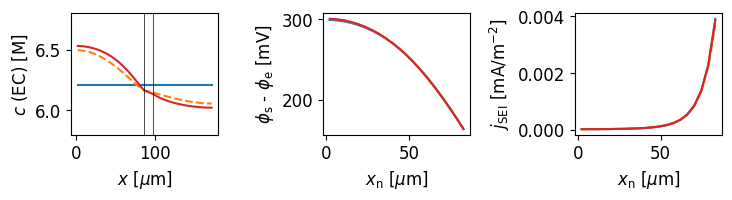

In [7]:
# plot only things happen during 3C CC charge
fs = 12; font = {'family' : 'DejaVu Sans','size'   : fs}
mpl.rc('font', **font)
def FindClose(time_DD,t_select): # Input must be a list
    for i in range(0,len(time_DD)):
        if abs(time_DD[i] - t_select)<1e-3:
            break
    return i
Colors = ['#1f77b4','#ff7f0e',  '#d62728', ];
LS = ['-','--','-','--',];MS=['s','^','h']; ms = 8
Sol_plt = [sol_SD,sol_DD_LDx,sol_DD_HDx,];
Str = ["Single",r"Double low D$_\times$",r"Double high D$_\times$"]

t_int_all = []; Index_t_select = []; 

for i in range(3):
    sol = Sol_plt[i]; step_CC =  sol.cycles[0].steps[2]
    t_int_all.append((
        step_CC['Time [s]'].entries
        - step_CC['Time [s]'].entries[0]).tolist())
    print(t_int_all[-1])
t_select = min(t_int_all[0][-2],t_int_all[1][-2],t_int_all[2][-2])
for i in range(3):
    Index_t_select.append(FindClose(t_int_all[i],t_select))
print(Index_t_select,t_select)

fig, axs = plt.subplots(1,3, figsize=(19/2.54,5.5/2.54),tight_layout=True)
for i in range(3):
    sol = Sol_plt[i]; step_CC =  sol.cycles[0].steps[2]
    x =   step_CC["x [m]"].entries[:,0]
    x_n =   step_CC["x_n [m]"].entries[:,0]
    c_EC =   step_CC["EC concentration [mol.m-3]"].entries[:,Index_t_select[i]]
    j_SEI =   step_CC["Negative electrode SEI interfacial current density [A.m-2]"].entries[:,Index_t_select[i]]
    phi_s_phi_e =   step_CC["Negative electrode surface potential difference [V]"].entries[:,Index_t_select[i]]

    axs[0].plot(x*1e6, c_EC/1e3, color=Colors[i],linestyle=LS[i],) # label=r"Single-High $D_\times$" 
    axs[1].plot(x_n*1e6, phi_s_phi_e*1e3, color=Colors[i],linestyle=LS[i]) 
    axs[2].plot(x_n*1e6, abs(j_SEI)*1e3, color=Colors[i],linestyle=LS[i]) 
Y_0p = np.arange(-100,200,50)
axs[0].plot( 85.2 * np.ones_like(Y_0p),Y_0p,"k-",linewidth=0.5,)
axs[0].plot((85.2+12 )* np.ones_like(Y_0p),Y_0p, "k-",linewidth=0.5,)


axs[0].set_xlabel(r"$\mathit{x}$ [$\mu$m]",   )
axs[1].set_xlabel(r"$\mathit{x}_\mathrm{n}$ [$\mu$m]",   )
axs[2].set_xlabel(r"$\mathit{x}_\mathrm{n}$ [$\mu$m]",   )
axs[0].set_ylabel("$\mathit{c}$ (EC) [M]")
axs[1].set_ylabel("$\phi$$_\mathrm{s}$ - $\phi$$_\mathrm{e}$ [mV]")
axs[2].set_ylabel("$\mathit{j}_\mathrm{SEI}$ [mA/m$^{-2}$]")
axs[0].ticklabel_format( 
    axis='x', style='sci',
    scilimits=[-1e3,1e3], useOffset=None, 
    useLocale=None, useMathText=None)

axs[0].set_ylim([5.8,6.8])
#axs[1].set_ylim([-90,130])
#axs[2].set_ylim([-0.1,75])
fig.subplots_adjust(wspace=0, hspace=0)
# 85.2 ; 12; 75.6

plt.savefig(BasicPath +  Target+ 
    f"Fig_6_2C_c_EC_j_SEI.png", dpi=1000)
plt.savefig(BasicPath +  Target+ 
    f"Fig_6_2C_c_EC_j_SEI.svg")   